 # CAM 

This notebook is based on code found at: 

https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html


In [1]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import torch
import numpy as np
import skimage.transform

## Import
Import image that we want to classify. Based on code from SML course UU - lab exercise

RGB image of size (683, 683)


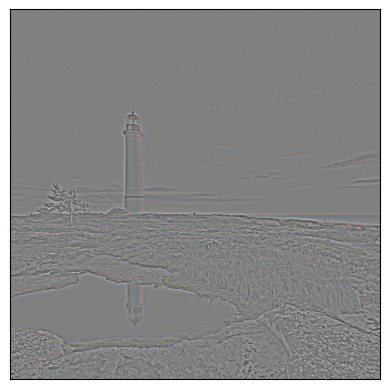

In [2]:
from urllib.request import urlopen
from urllib.error import URLError
import matplotlib.pyplot as plt

image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/640px-Felis_catus-cat_on_snow.jpg'

lighthouse_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_original.jpg?raw=true'
lighthouse_90deg_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_90deg.jpg?raw=true'
lighthouse_blur_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_blur.jpg?raw=true'
lighthouse_highpass_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_highpass.jpg?raw=true'
lighthouse_mix_channel_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_mix_channel.jpg?raw=true'
lighthouse_noise_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_noise.jpg?raw=true'
lighthouse_equalized_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse%20equalized.jpg?raw=true'

lighthouse_url_list = [
    lighthouse_url,
    lighthouse_90deg_url,
    lighthouse_blur_url,
    lighthouse_highpass_url,
    lighthouse_mix_channel_url,
    lighthouse_noise_url,
    lighthouse_equalized_url   
]

description = ['Original', '90deg', 'Gaussian blur', 'Highpass filtered', 'Mixed color channels', 'Noise', 'Hist.equalized']

lighthouse_image_list = []
for i in range(len(lighthouse_url_list)):
    
    try:
        with Image.open(urlopen(lighthouse_url_list[i])) as im:
            # The following fixes some problems when loading images:
            # https://stackoverflow.com/a/64598016
            lighthouse_image_list.append(im.convert("RGB"))
    except (URLError, OSError):
        print("please provide a valid URL or local path")


 
print(f"{lighthouse_image_list[3].mode} image of size {lighthouse_image_list[3].size}")
plt.imshow(np.asarray(lighthouse_image_list[3]))
plt.xticks([])
plt.yticks([])
plt.show()

Store class names in a dictionary

In [3]:
# Define the URL of the raw text file on GitHub
class_name = {}

# Define the URL of the raw text file on GitHub
url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

try:
    # Open the URL and read the contents of the file
    with urlopen(url) as response:
        text = response.read().decode('utf-8')
        text = text.replace('{', '')
        text = text.replace('}', '')

        for line in text.splitlines():
            key, value = line.split(':')
            key = int(key)
    
            if value.count(',') >= 2:
                value = value.replace(',', '\n', 1)
            # remove last , if present
            if value.endswith(','):
                value = value[:-1]

            class_name[key] = value.replace("'", "")

except URLError as e:
    print("please provide a valid URL or local path")

# set  beacon, lighthouse, beacon light, pharos to lighthouse for less printing
class_name[437] = 'lighthouse'

# print some random class names


Import the 3 images for attention maps

In [4]:
sandal_url = "https://raw.githubusercontent.com/Okrash0/Explainable-Artificial-Intelligence/main/fig/sandal.jpg"
toilet_url = "https://raw.githubusercontent.com/Okrash0/Explainable-Artificial-Intelligence/main/fig/toilet.jpg"

In [5]:
image_url_list = [sandal_url, toilet_url]
image_list = []

for i in range(len(image_url_list)):
    
    try:
        with Image.open(urlopen(image_url_list[i])) as im:
            # The following fixes some problems when loading images:
            # https://stackoverflow.com/a/64598016
            image_list.append(im.convert("RGB"))
    except (URLError, OSError):
        print("please provide a valid URL or local path")

image_name_list = ["toilet", "sandal", "lighthouse"]

image_list.append(lighthouse_image_list[0])

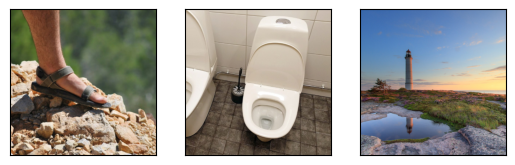

In [6]:
# show images in subplots 
fig, axs = plt.subplots(1, len(image_list))
for i in range(len(image_list)):
    axs[i].imshow(np.asarray(image_list[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

## Preprocess 

In [7]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [8]:
lighthouse_tensors = []
for i in range(len(lighthouse_image_list)):
    lighthouse_tensors.append(preprocess(lighthouse_image_list[i]))

In [9]:
image_tensors = []
for i in range(len(image_list)):
    image_tensors.append(preprocess(image_list[i]))

In [10]:
prediction_var_list = []
for i in range(len(lighthouse_image_list)):
    prediction_var_list.append(Variable((lighthouse_tensors[i].unsqueeze(0)), requires_grad=True))


In [11]:
prediction_var_list_image = []
for i in range(len(image_list)):
    prediction_var_list_image.append(Variable((image_tensors[i].unsqueeze(0)), requires_grad=True))

## Load model

In [12]:
model = models.resnet18(pretrained=True)

/Users/falk/Documents/python_projects/DL4IA_assignment_4/Explainable-Artificial-Intelligence/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/falk/Documents/python_projects/DL4IA_assignment_4/Explainable-Artificial-Intelligence/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model.eval();

In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [15]:
final_layer = model._modules.get('layer4')

In [16]:
activated_features = SaveFeatures(final_layer)

## Make prediction

In [17]:
pred_probabilities_list = []

for i in range(len(lighthouse_tensors)):
    prediction = model(prediction_var_list[i])
    pred_probabilities_list.append(F.softmax(prediction).data.squeeze())
    activated_features.remove()



/var/folders/gz/cp34mcp54pn6gmdlbwkdhdwh0000gn/T/ipykernel_11286/2287866501.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities_list.append(F.softmax(prediction).data.squeeze())


In [18]:
for i in range(len(lighthouse_tensors)):
    topk(pred_probabilities_list[i],1)
    print(topk(pred_probabilities_list[i],1))

torch.return_types.topk(
values=tensor([0.9973]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.6106]),
indices=tensor([972]))
torch.return_types.topk(
values=tensor([0.7377]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.1081]),
indices=tensor([646]))
torch.return_types.topk(
values=tensor([0.9865]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9774]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9987]),
indices=tensor([437]))


 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
 
437: 'beacon, lighthouse, beacon light, pharos',

In [19]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [20]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [21]:
weight_softmax_params;

In [22]:
overlay_list = []
class_list = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],1)[1].int()
    overlay_list.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list.append(class_idx)
    print(topk(pred_probabilities_list[i],1))
    activated_features.remove()

torch.return_types.topk(
values=tensor([0.9973]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.6106]),
indices=tensor([972]))
torch.return_types.topk(
values=tensor([0.7377]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.1081]),
indices=tensor([646]))
torch.return_types.topk(
values=tensor([0.9865]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9774]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9987]),
indices=tensor([437]))


In [1]:
#print(overlay_list)

## Plot heatmap of predicted class

Ploting functions

In [24]:
def plot_heatmap(overlay_images, titles, save_plot=False):
    """plot heatmap of images with titles
    Args: 
        overlay_images: list of overlay images
        titles: list of titles
        save_plot: bool, save plot or not
    """

    n = len(overlay_images)
    _, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(overlay_images[i][0], alpha=0.5, cmap='jet')
        ax.set_title(titles[i].item())
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()


def plot_images(images, titles, save_plot=False):
    """plot images with titles
    Args:
        images: list of images
        titles: list of titles
        save_plot: bool, save plot or not

    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()


def plot_images_overlay(images, tensor, overlay_list, titles, save_plot=False):
    """plot images with titles and overlay
    Args:
        images: list of images
        tensor: list of images
        overlay_list: list of overlay images
        titles: list of tensors with class index
    
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(display_transform(images[i]))
        ax.imshow(skimage.transform.resize(
            overlay_list[i][0], tensor[i].shape[1:3]), alpha=0.5, cmap='jet')
        ax.set_title(class_name[titles[i].item()])
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()


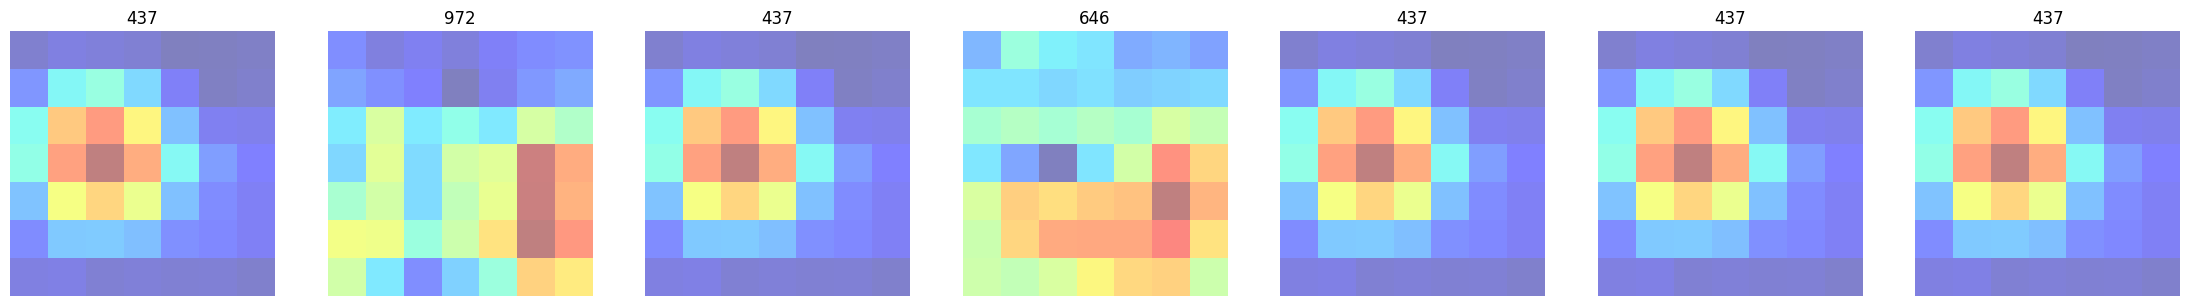

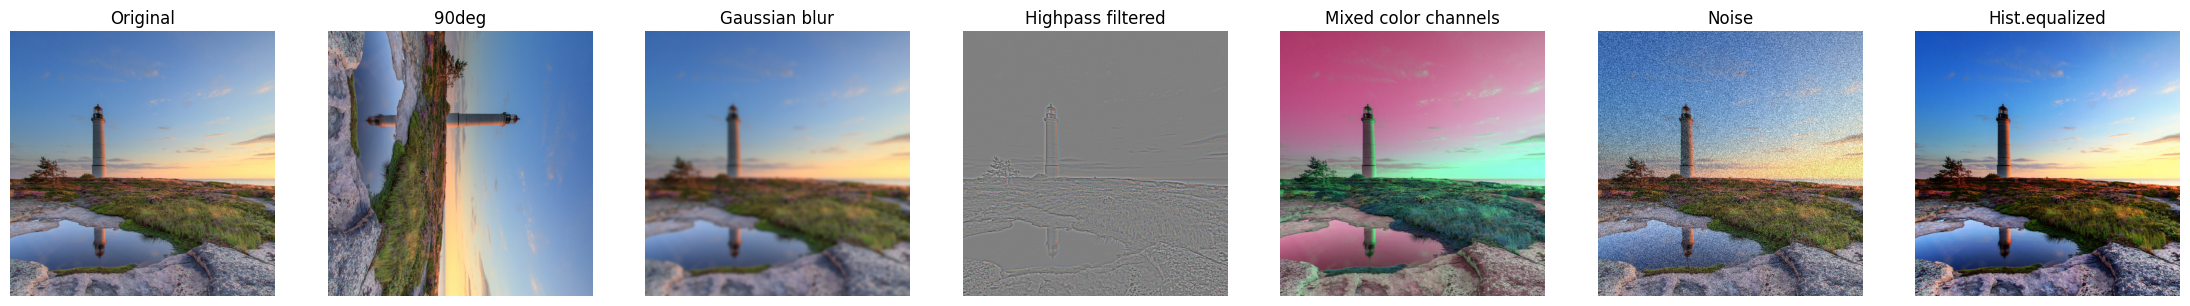

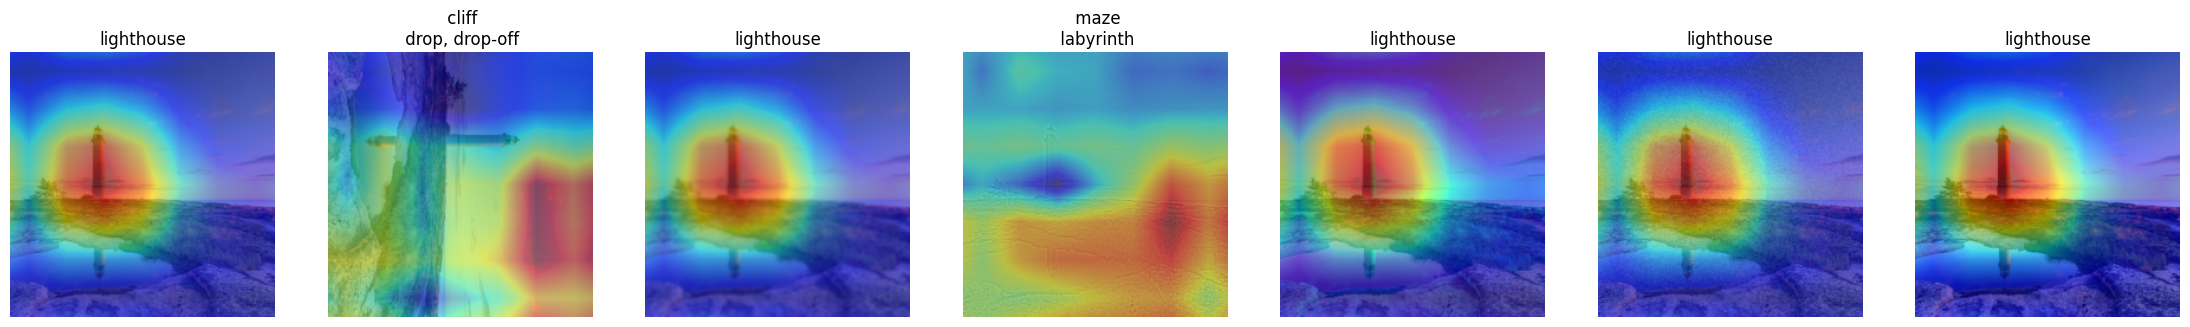

In [25]:
plot_heatmap(overlay_list, class_list)
plot_images(lighthouse_image_list, description)
plot_images_overlay(lighthouse_image_list, lighthouse_tensors, overlay_list, class_list)

 437: 'beacon, lighthouse, beacon light, pharos',
 
 972: 'cliff, drop, drop-off',
 
 646: 'maze, labyrinth',
 

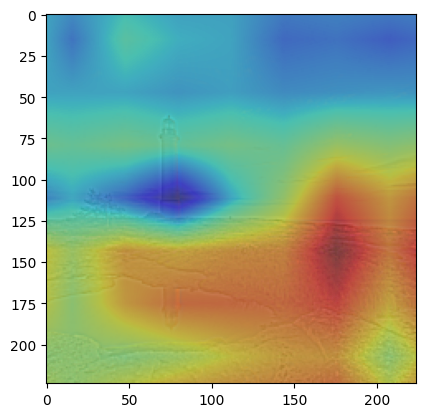

In [26]:
imshow(display_transform(lighthouse_image_list[3]))
imshow(skimage.transform.resize(overlay_list[3][0], lighthouse_tensors[0].shape[1:3]), alpha=0.5, cmap='jet');

## Plot heatmap of second predected class

In [27]:
overlay_list_sec = []
class_list_sec = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],2)[1].int()
    print(topk(pred_probabilities_list[i],2))
    class_idx = class_idx[1]
    overlay_list_sec.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list_sec.append(class_idx)
    activated_features.remove()


torch.return_types.topk(
values=tensor([9.9725e-01, 3.2850e-04]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([0.6106, 0.0701]),
indices=tensor([972, 976]))
torch.return_types.topk(
values=tensor([0.7377, 0.0419]),
indices=tensor([437, 975]))
torch.return_types.topk(
values=tensor([0.1081, 0.0844]),
indices=tensor([646,  50]))
torch.return_types.topk(
values=tensor([0.9865, 0.0021]),
indices=tensor([437, 460]))
torch.return_types.topk(
values=tensor([0.9774, 0.0043]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([9.9873e-01, 2.8490e-04]),
indices=tensor([437, 497]))


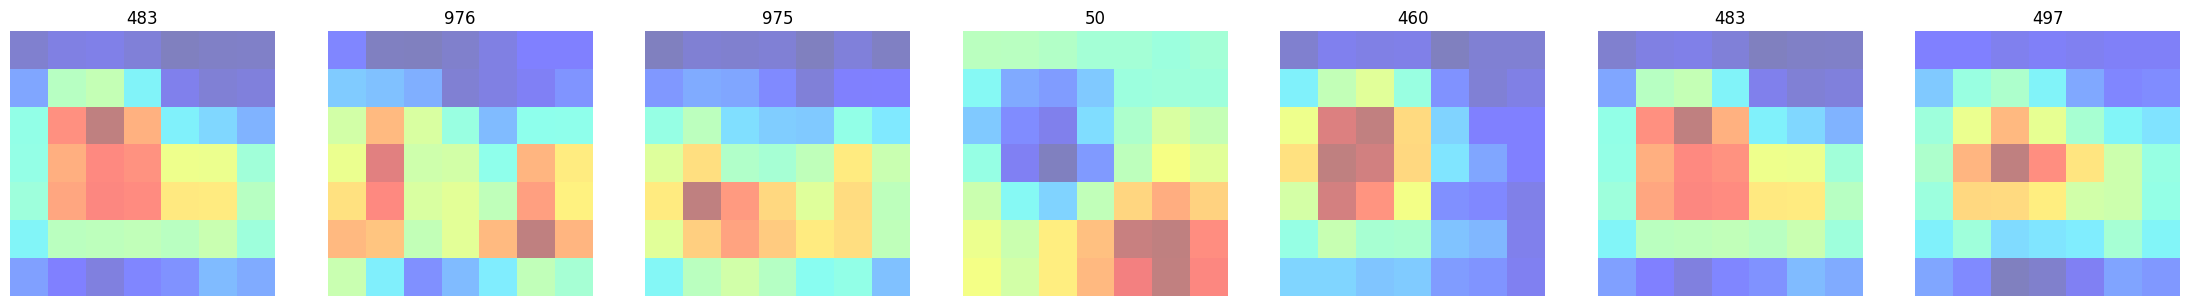

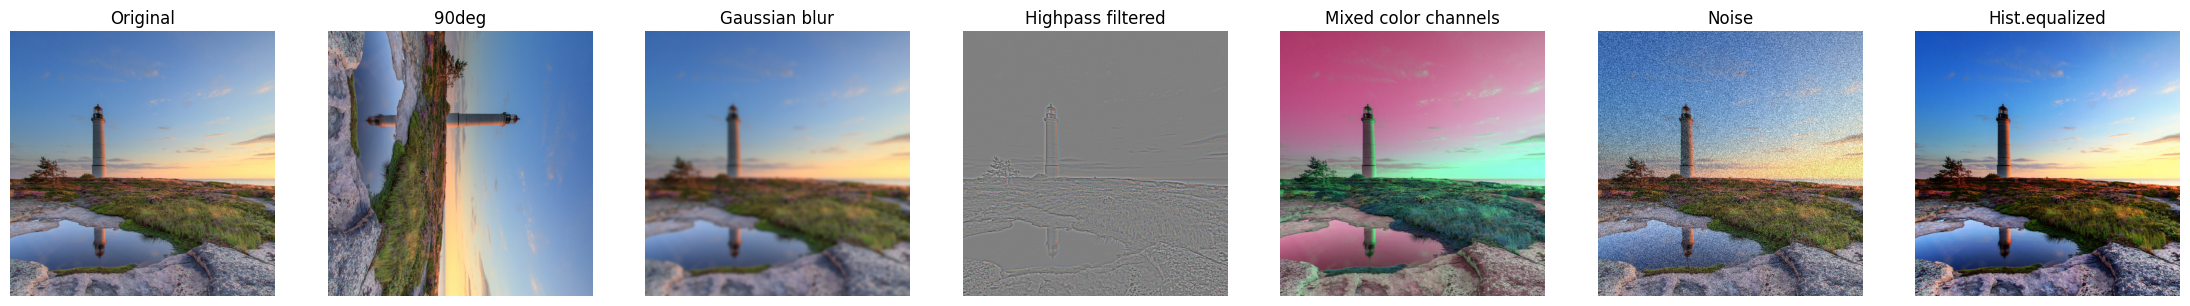

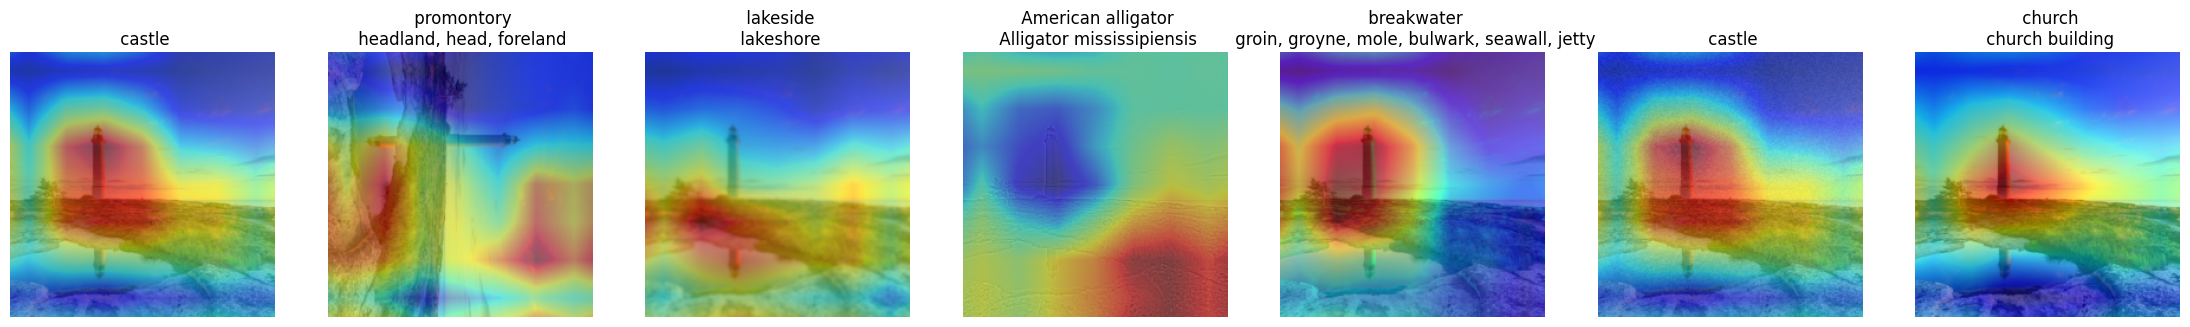

In [28]:
plot_heatmap(overlay_list_sec, class_list_sec)
plot_images(lighthouse_image_list, description)
plot_images_overlay(lighthouse_image_list, lighthouse_tensors ,overlay_list_sec, class_list_sec)

Second choice

483: 'castle' [3.2850e-04]

976: 'promontory, headland, head, foreland' [0.0701]

975: 'lakeside, lakeshore', [0.0419]

50: 'American alligator, Alligator mississipiensis',[0.0419]

460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty', [0.0021]

483: 'castle', [0.0043]

497: 'church, church building', [2.8490e-04]



## Plot heatmap of other classes
Lets check the heat map for some other classes 

*   527: 'desktop computer'
*   587: 'hammer'
*   497: 'church, church building',


In [29]:
other_class = 497

overlay_list_otherclass = []
class_list_otherclass = []
for i in range(len(lighthouse_tensors)):
    input_image = prediction_var_list[i]
    prediction = model(input_image) 
    class_idx = topk(prediction, 2)[1].int()
    overlay_list_otherclass.append(getCAM(activated_features.features, weight_softmax, other_class))
    
    class_list_otherclass.append(torch.tensor(other_class, dtype=torch.int32))
    activated_features.remove()



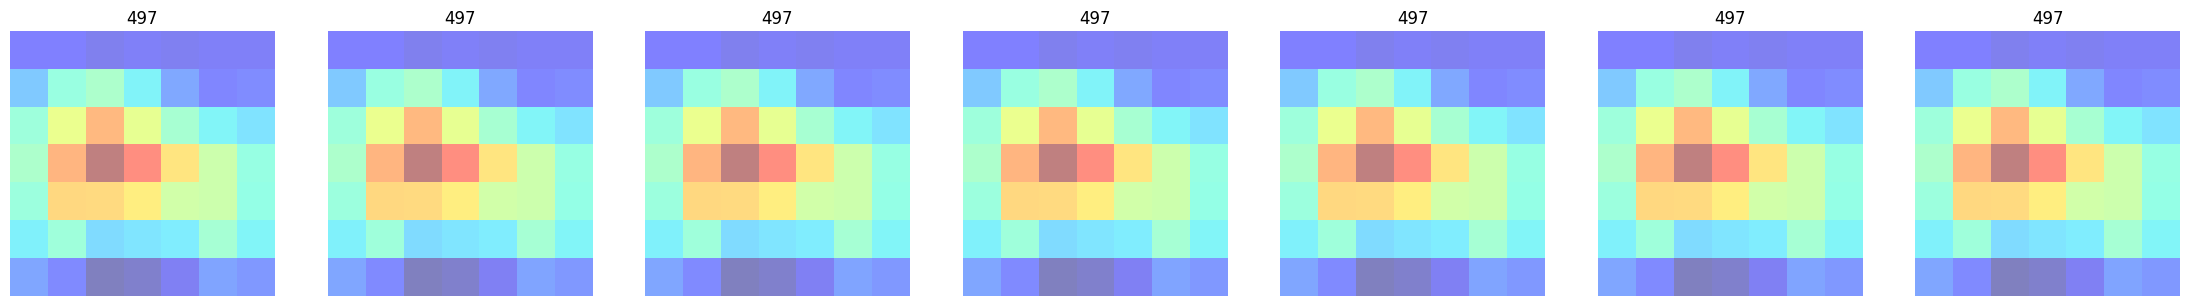

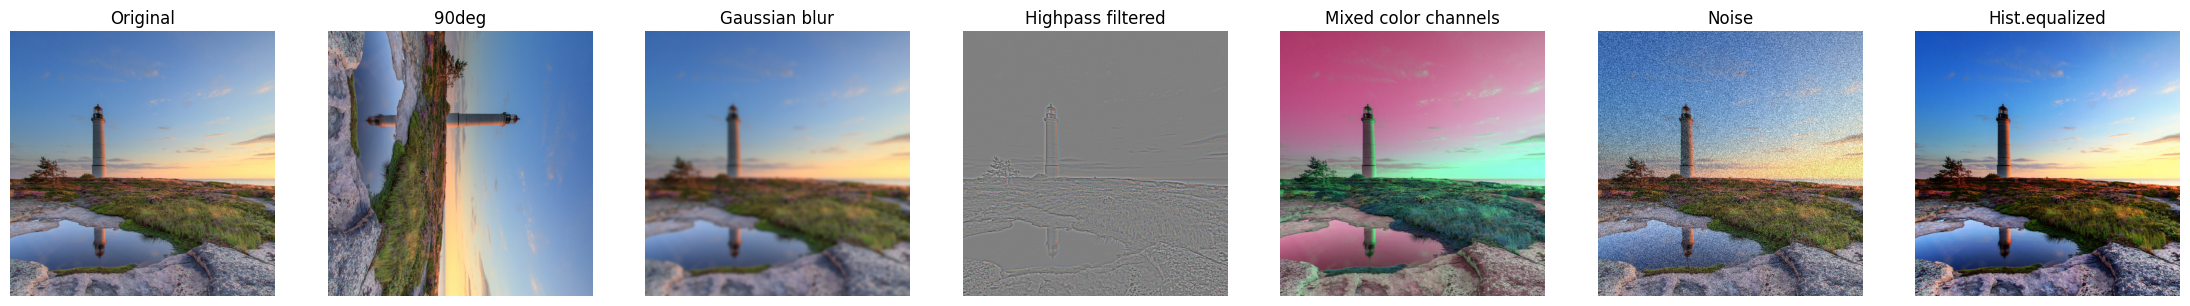

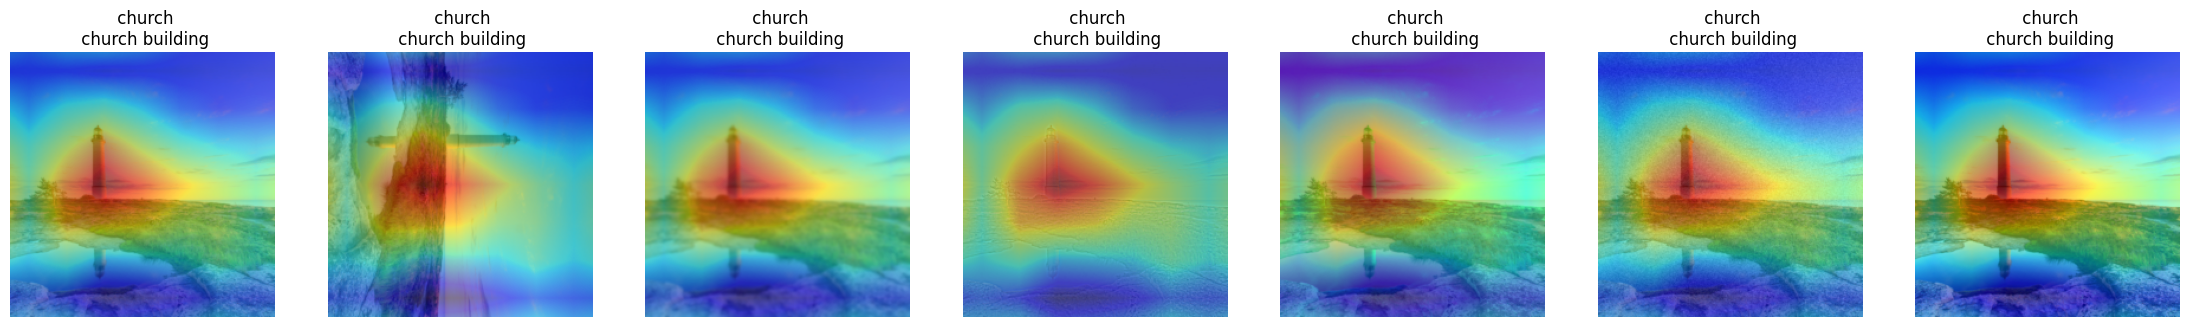

In [30]:
plot_heatmap(overlay_list_otherclass, class_list_otherclass)
plot_images(lighthouse_image_list, description)
plot_images_overlay(lighthouse_image_list,
                    lighthouse_tensors, overlay_list_otherclass, class_list_otherclass)


# Heatmap of other classes

Make prediciton

In [31]:
pred_probabilities_list_image = []

for i in range(len(image_tensors)):
    prediction = model(prediction_var_list_image[i])
    pred_probabilities_list_image.append(F.softmax(prediction).data.squeeze())
    activated_features.remove()

print("Probability and predicted class:")
for i in range(len(image_tensors)):
    probs = topk(pred_probabilities_list_image[i],1)
    # print probabilities and predicted classes
    print(class_name[probs[1].item()], probs[0].item())

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

overlay_list = []
class_list = []
for i in range(len(image_tensors)):
    class_idx = topk(pred_probabilities_list_image[i],1)[1].int()
    overlay_list.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list.append(class_idx)
    activated_features.remove()

Probability and predicted class:
 hatchet 0.5540675520896912
 toilet seat 0.9991310238838196
lighthouse 0.9972507357597351


/var/folders/gz/cp34mcp54pn6gmdlbwkdhdwh0000gn/T/ipykernel_11286/1302828530.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities_list_image.append(F.softmax(prediction).data.squeeze())


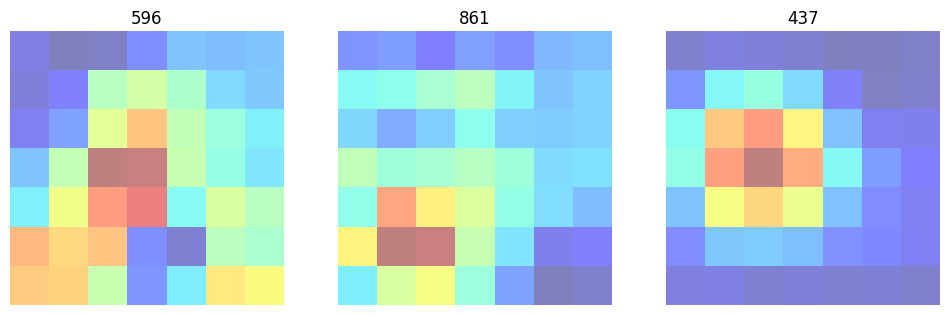

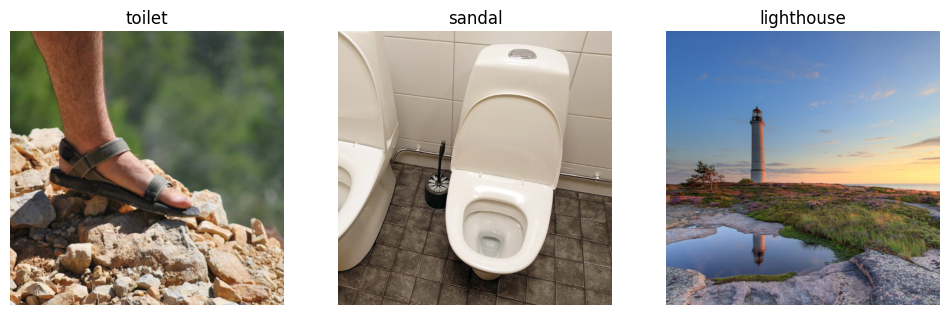

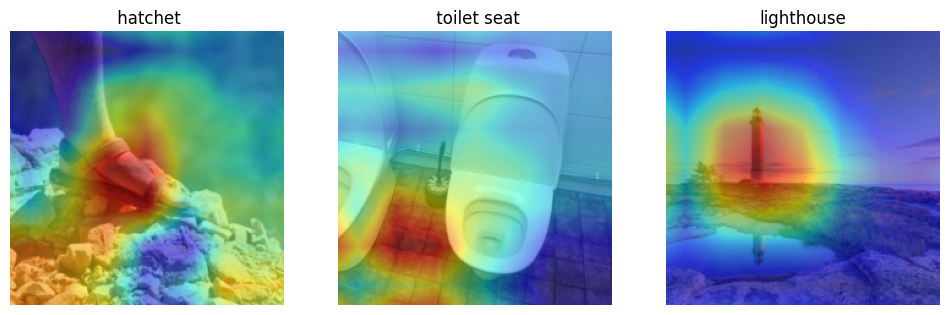

In [32]:
plot_heatmap(overlay_list, class_list)
plot_images(image_list, image_name_list)
plot_images_overlay(image_list, image_tensors, overlay_list, class_list)


# LRP

/Users/falk/Documents/python_projects/DL4IA_assignment_4/Explainable-Artificial-Intelligence/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


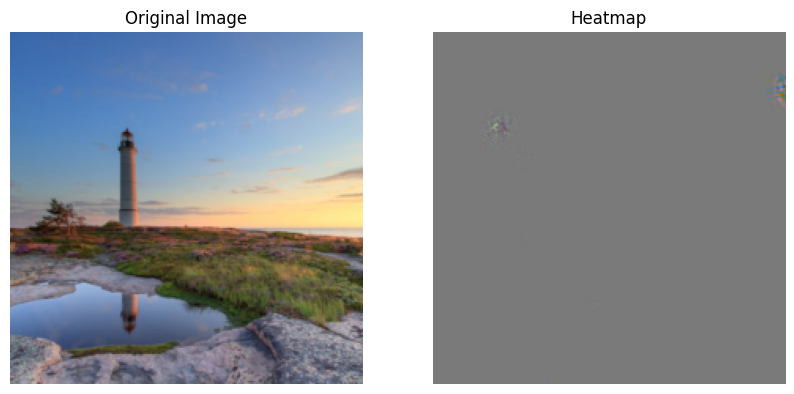

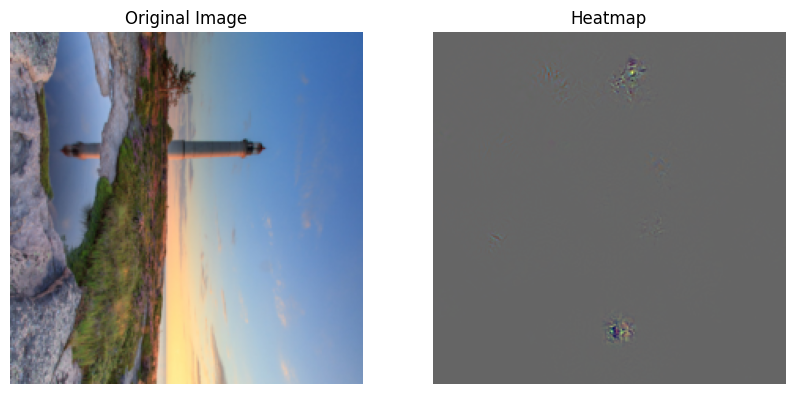

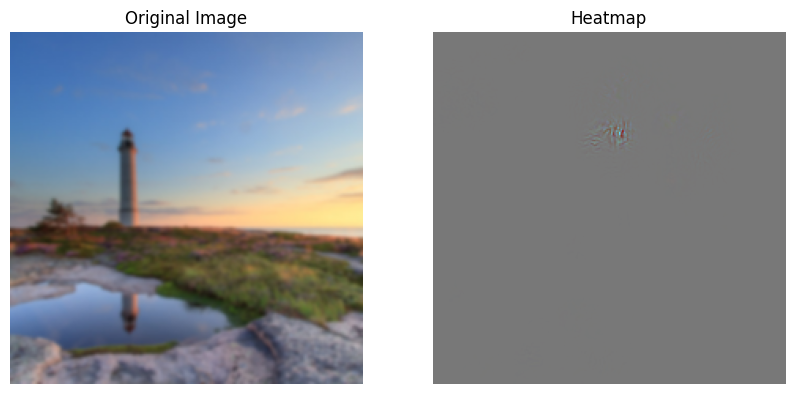

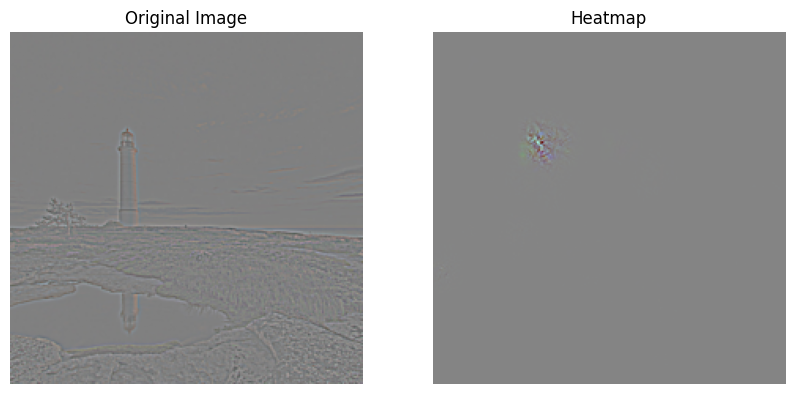

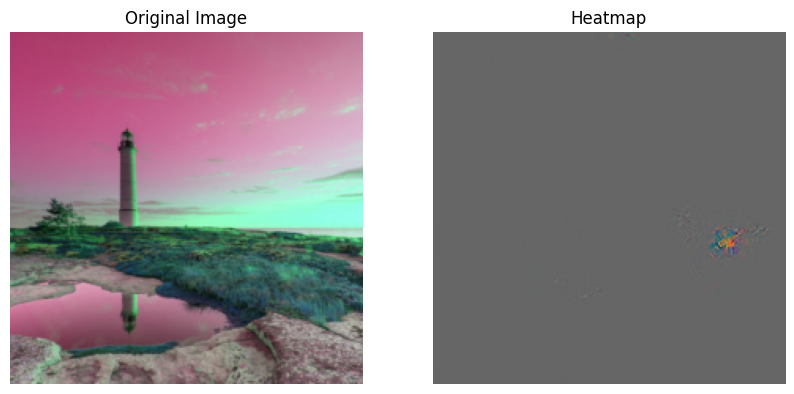

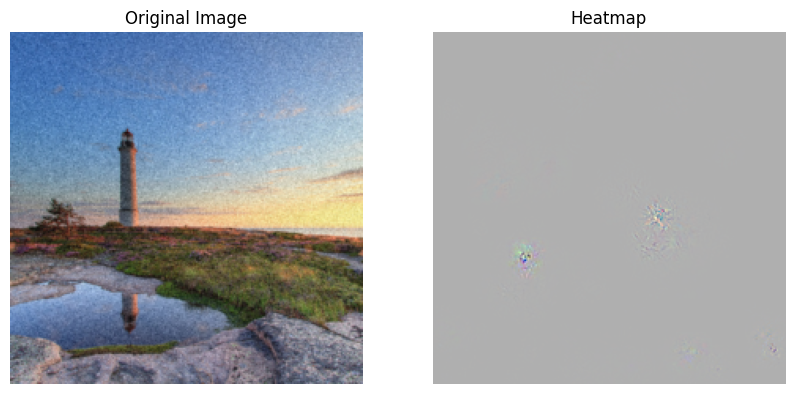

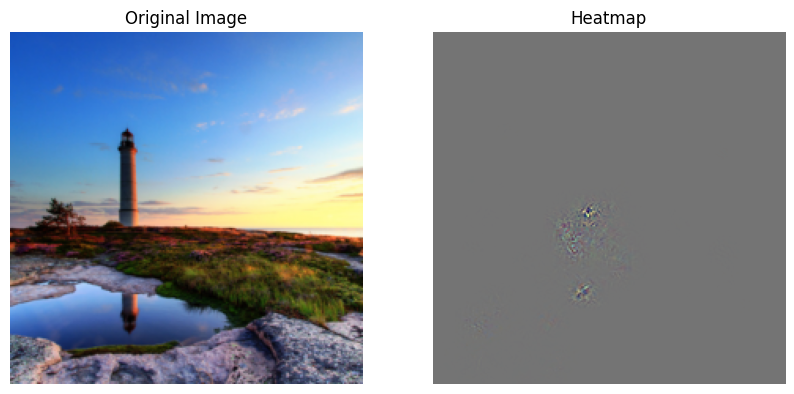

In [33]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
from captum.attr import LRP
from captum.attr import visualization as viz
from urllib.request import urlopen
from urllib.error import URLError


# Preprocessing and display_transform functions
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

display_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

threshold = 0.9


# Process each image in the list
for idx, input_image in enumerate(lighthouse_image_list):
    preprocessed_image = preprocess(input_image).unsqueeze(0)

    # Get the predicted class index
    output = model(preprocessed_image)
    _, pred_class = torch.max(output, 1)
    pred_class_idx = pred_class.item()

    # Compute LRP attributions
    lrp = LRP(model)
    attributions = lrp.attribute(preprocessed_image, target=pred_class_idx)

    # Visualize the attributions
    attributions_np = attributions.squeeze().detach().numpy()
    original_image_np = display_transform(input_image)
    original_image_np = np.array(original_image_np) / 255.0

    # Normalize the attributions
    attributions_np = (attributions_np - np.min(attributions_np)) / (np.max(attributions_np) - np.min(attributions_np))

    # Fix the flipped heatmap
    attributions_np = np.flip(attributions_np, axis=2)

    # Swap the axes of the attributions array
    attributions_np = np.transpose(attributions_np, (1, 2, 0))

    # Create a subplot for the original image and the heatmap
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(attributions_np, cmap='viridis')
    axs[1].set_title('Heatmap')
    axs[1].axis('off')

    plt.show()


